In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [2]:
dataset_path = r"D:\Deep Learning project\datatwo"
dataset_dir = pathlib.Path(dataset_path)

In [3]:
# Getting class names from subdirectories
class_names = [item.name for item in dataset_dir.iterdir() if item.is_dir()]
print(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [4]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [5]:
# Loading data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 1570 files belonging to 7 classes.
Using 1256 files for training.


In [6]:
# Loading data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 1570 files belonging to 7 classes.
Using 314 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)
num_classes=len(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


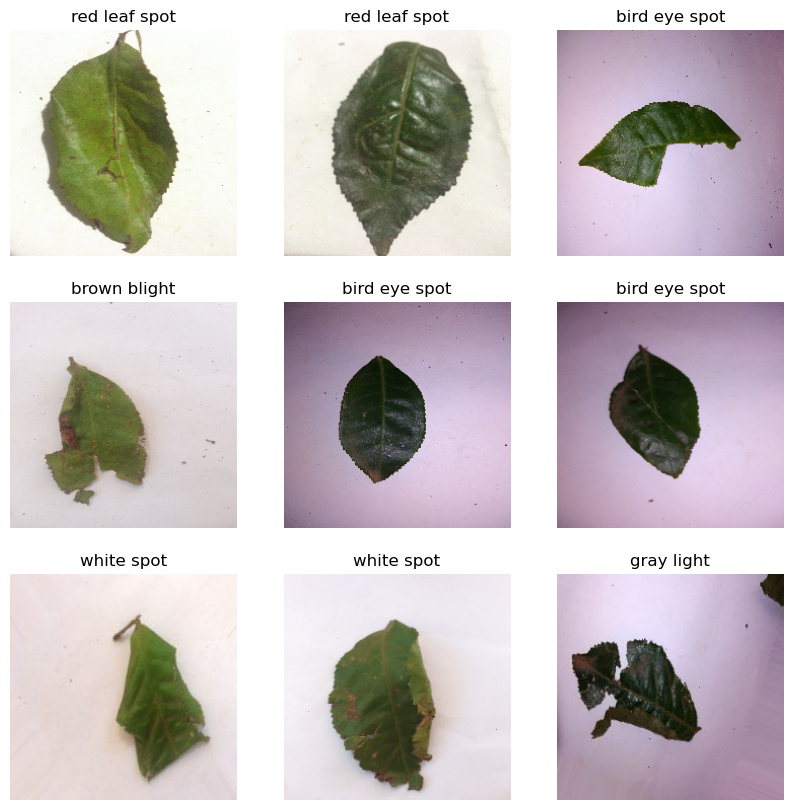

In [8]:
# Review 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
#optimizing the performance of input data pipeline --TensorFlow
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [11]:
from tensorflow.keras.layers import PReLU

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same'),
    PReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same'),
    PReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same'),
    PReLU(),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64),
    PReLU(),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])


In [12]:
# compiling model
base_learning_rate = 0.0005
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 p_re_lu (PReLU)             (None, 224, 224, 32)      1605632   
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                      

In [14]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

In [15]:
epochs = 320
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/320



D:\Softwares\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



10/10 [==============================] - 110s 8s/step - loss: 1.9034 - accuracy: 0.2277 - val_loss: 1.9189 - val_accuracy: 0.1815
Epoch 2/320
10/10 [==============================] - 74s 8s/step - loss: 1.6886 - accuracy: 0.3185 - val_loss: 1.9010 - val_accuracy: 0.2484
Epoch 3/320
10/10 [==============================] - 78s 8s/step - loss: 1.4997 - accuracy: 0.3869 - val_loss: 1.8797 - val_accuracy: 0.3217
Epoch 4/320
10/10 [==============================] - 73s 7s/step - loss: 1.3230 - accuracy: 0.4379 - val_loss: 1.8465 - val_accuracy: 0.4140
Epoch 5/320
10/10 [==============================] - 71s 7s/step - loss: 1.2658 - accuracy: 0.4347 - val_loss: 1.8211 - val_accuracy: 0.4363
Epoch 6/320
10/10 [==============================] - 72s 7s/step - loss: 1.1712 - accuracy: 0.4873 - val_loss: 1.7896 - val_accuracy: 0.4809
Epoch 7/320
10/10 [==============================] - 70s 7s/step - loss: 1.1577 - accuracy: 0.5080 - val_loss: 1.7678 - val_accuracy: 0.4427
Epoch 8/320
10/10 [====

10/10 [==============================] - 73s 7s/step - loss: 0.5299 - accuracy: 0.7771 - val_loss: 0.7365 - val_accuracy: 0.6656
Epoch 58/320
10/10 [==============================] - 70s 7s/step - loss: 0.5309 - accuracy: 0.7866 - val_loss: 0.6435 - val_accuracy: 0.7102
Epoch 59/320
10/10 [==============================] - 70s 7s/step - loss: 0.5063 - accuracy: 0.7962 - val_loss: 0.5630 - val_accuracy: 0.7866
Epoch 60/320
10/10 [==============================] - 71s 7s/step - loss: 0.4863 - accuracy: 0.8033 - val_loss: 0.6695 - val_accuracy: 0.6911
Epoch 61/320
10/10 [==============================] - 70s 7s/step - loss: 0.4982 - accuracy: 0.8065 - val_loss: 0.5576 - val_accuracy: 0.7516
Epoch 62/320
10/10 [==============================] - 70s 7s/step - loss: 0.4644 - accuracy: 0.8113 - val_loss: 0.7929 - val_accuracy: 0.6338
Epoch 63/320
10/10 [==============================] - 71s 7s/step - loss: 0.4548 - accuracy: 0.8280 - val_loss: 0.6167 - val_accuracy: 0.7325
Epoch 64/320
10/10 

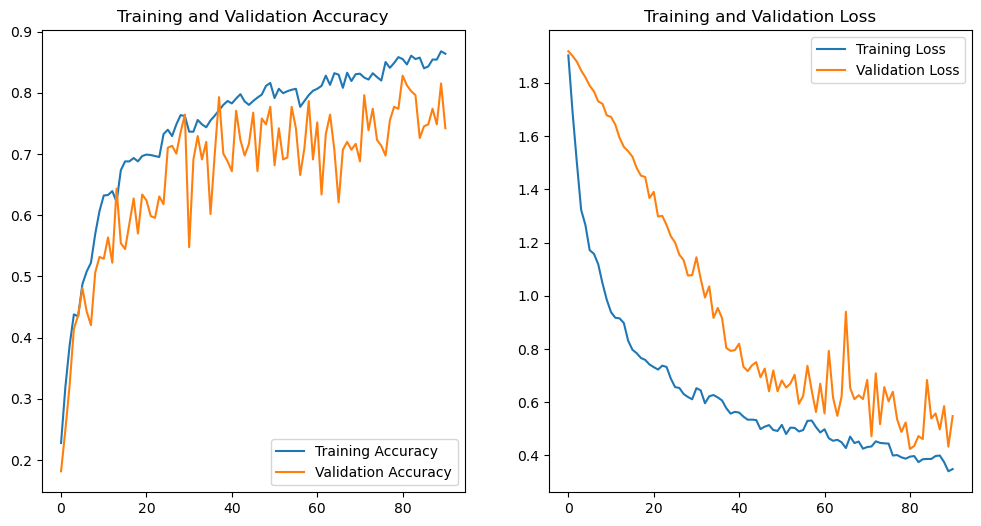

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

3/3 [==============================] - 5s 1s/step


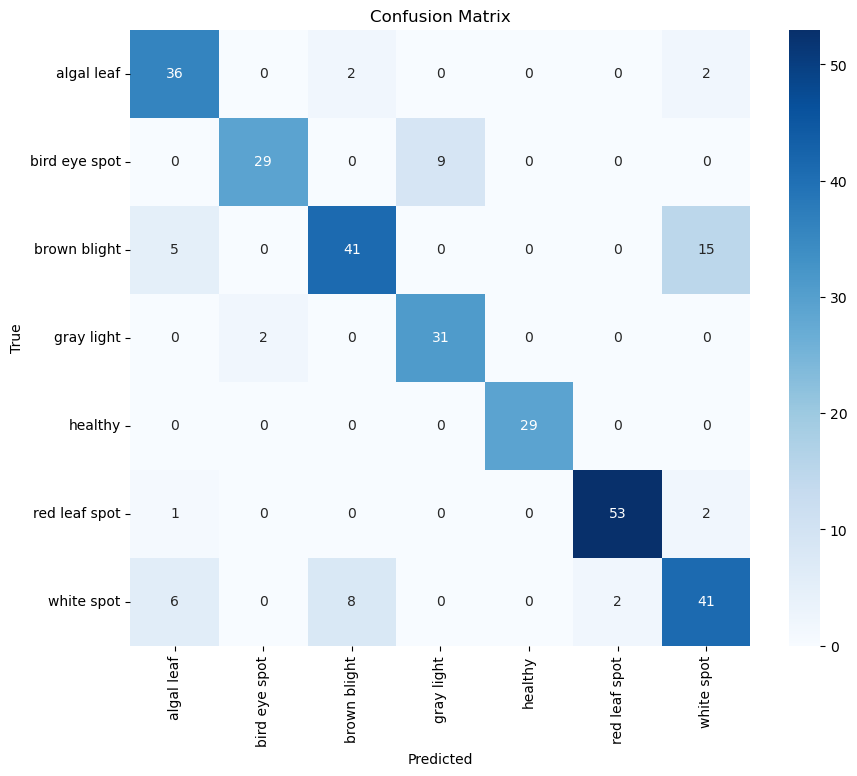

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)


true_labels = []
for _, labels in val_ds:
    true_labels.extend(labels.numpy())


conf_mat = confusion_matrix(true_labels, val_predictions)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Predictions:
 [6 0 4 2 0 6 3 4 1 3 3 2 5 5 2 5 0 5 4 6 6 6 3 0 5 6 4 5 3 2 1 2 2 5 2 5 1
 6 6 6 3 0 2 2 1 2 3 6 4 3 6 5 2 4 3 6 6 6 1 2 1 3 5 5 0 1 2 1 5 6 3 6 5 4
 2 6 3 1 5 5 3 4 0 2 5 0 1 3 3 3 6 5 3 0 2 2 1 0 0 3 4 3 5 6 6 5 6 2 2 3 4
 0 3 0 3 4 2 5 6 0 2 4 6 5 5 2 5 0]
Labels:
 [6 0 4 2 0 2 3 4 1 3 1 6 5 5 0 5 0 5 4 6 6 6 3 2 5 2 4 5 3 2 1 2 2 5 2 5 1
 6 6 6 1 5 2 6 1 2 3 6 4 3 2 5 2 4 3 6 6 2 1 2 1 3 5 5 0 3 2 1 5 2 3 6 5 4
 6 6 3 1 5 5 1 4 2 2 5 0 1 3 3 1 6 5 3 0 2 2 1 0 6 3 4 3 5 6 2 5 6 2 2 3 4
 0 3 0 3 4 2 5 6 0 2 4 6 6 5 2 5 2]

              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.91      0.71      0.80        14
           2       0.82      0.67      0.73        27
           3       0.82      0.95      0.88        19
           4       1.00      1.00      1.00        12
           5       0.96      0.96      0.96        23
           6       0.74      0.77      0.76        22

    accuracy        

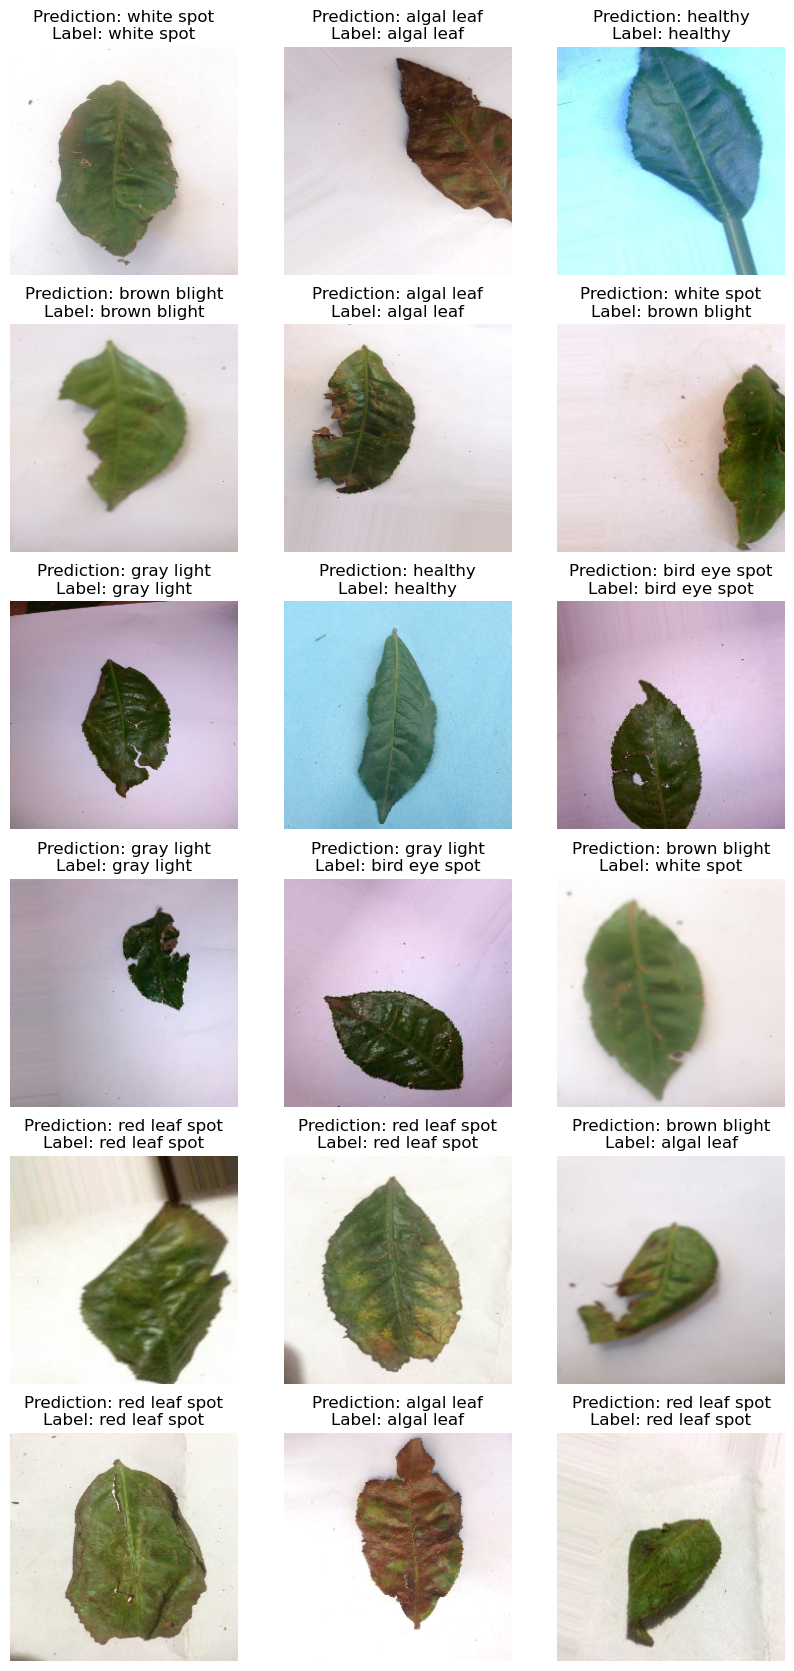

In [18]:

image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [21]:
model.save("D:\Deep Learning project/modelV3_PRelu")

INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV3_PRelu\assets


INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV3_PRelu\assets
